# German Traffic Sign Recognition
## w281 Computer Vision
### Final Project


In [379]:
# importing libraries
import tensorflow 
import keras  
import os
import glob 
from skimage import io 
import random 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  
from matplotlib import colors
from matplotlib.ticker import PercentFormatter


In [157]:
dataset_path = './gmb/'

In [505]:
class DataLoad:
    def __init__(self, path):
        self.path = path
        self.class_data = None
        self.train_meta = None
        self.train_data = []
        self.test_meta = None
        self.test_data = []
        
    def load_meta(self):
        self.class_data = pd.read_csv('./MetaCSV/meta_1.csv')
        self.class_data = self.class_data.sort_values(by=['ClassId'])
        self.class_rows = self.class_data.shape[0]
        
    def display_meta(self):
        if self.class_data is not None:
            fig, ax = plt.subplots(nrows=6, ncols=8, figsize=(11, 11))
            c = 0
            for r, (file, title) in enumerate(zip(self.class_data['Path'], self.class_data['Description'])):
                ax[r//8, c%8].imshow(plt.imread(self.path + file))
                ax[r//8, c%8].axis('off')
                ax[r//8, c%8].set_title(f'Class {r}', fontsize=8)
                c += 1
            for c in range(r, 48):
                ax[5,c%8].axis('off')
            plt.show()

    def load_train(self, remove=True):
        self.train_meta = pd.read_csv(self.path + 'Train.csv')
        self.train_meta = self.train_meta.sort_values(by=['ClassId'])
        if (remove is True):
            self.train_meta.drop_duplicates(['Path'])
        
        self.train_data = [(self.path + i_path, cl) for i_path, cl in zip(self.train_meta['Path'], self.train_meta['ClassId'])]
        self.train_rows = self.train_meta.shape[0]

    def display_train(self):
        if self.train_meta is not None:
            # Get random samples
            images = []
            for i in range(self.class_rows):
                images.append(self.train_meta[self.train_meta['ClassId'] == i].sample()['Path'].values.astype(str)[0])
            
            fig, ax = plt.subplots(nrows=6, ncols=8, figsize=(11, 11))
            c = 0
            for r, file in enumerate(images):
                ax[r//8, c%8].imshow(plt.imread(self.path + file))
                ax[r//8, c%8].axis('off')
                ax[r//8, c%8].set_title(f'Class {r}', fontsize=8)
                c += 1
            for i in range(r, 48):
                ax[5,i%8].axis('off')
            plt.show()
            
    def display_distribution(self, train_test='Train'):
        fig, axs = plt.subplots(1, 1, figsize =(10, 5), tight_layout=True)

        # Remove axes splines 
        for s in ['top', 'bottom', 'left', 'right']: 
            axs.spines[s].set_visible(False) 

        # Remove x, y ticks
#         axs.xaxis.set_ticks_position('none') 
#         axs.yaxis.set_ticks_position('none') 

        # Add padding between axes and labels 
        axs.xaxis.set_tick_params(pad = 5) 
        axs.yaxis.set_tick_params(pad = 5)
        
        axs.set_xticks(range(self.class_rows))

        # Add x, y gridlines 
        axs.grid(color ='grey', 
                linestyle ='-.', linewidth = 0.5, 
                alpha = 0.5)

#         # Add Text watermark 
#         fig.text(0.9, 0.15, 'German Traffic Sign class id', 
#                  fontsize = 12, 
#                  color ='black',
#                  ha ='right',
#                  va ='bottom', 
#                  alpha = 0.7) 

        # Create histogram
        if train_test == 'Train':
            data = self.train_meta['ClassId']
            titl = 'Distribution of Train Classes'
        else:
            data = self.test_meta['ClassId']
            titl = 'Distribution of Test Classes'
            
        N, bins, patches = axs.hist(data, bins=self.class_rows)

        # Setting color
        fracs = ((N**(1/8)) / N.max())
        norm = colors.Normalize(fracs.min(), fracs.max())

        for thisfrac, thispatch in zip(fracs, patches):
            color = plt.cm.magma(norm(thisfrac))
            thispatch.set_facecolor(color)

        # Adding extra features and Title 
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title(titl)
        plt.xticks(fontsize=9, rotation=60)
        plt.yticks(fontsize=10, rotation=0)
 
        # Show plot
        plt.show()


In [506]:
dl = DataLoad(dataset_path)

In [507]:
dl.load_meta()
dl.class_data.sample(10)

,Path,ClassId,ShapeId,ColorId,SignId,Description
4,Meta/11.png,11,0,0,1.22,Priority (right of way at next intersection)
41,Meta/8.png,8,1,0,3.29,Maximum speed limit (120 km/h)
12,Meta/19.png,19,0,0,1.2,Left curve
37,Meta/42.png,42,1,3,3.28,End of no passing zone for trucks
33,Meta/39.png,39,1,1,4.8,Pass by on left
16,Meta/22.png,22,0,0,1.1,Uneven road surface
30,Meta/36.png,36,1,1,4.4,Ahead or turn right only
20,Meta/26.png,26,0,0,1.24,Traffic signals ahead
1,Meta/0.png,0,1,0,3.29,Maximum speed limit (20 km/h)
34,Meta/4.png,4,1,0,3.29,Maximum speed limit (70 km/h)


In [508]:
# dl.display_meta()
# Display meta images


In [509]:
dl.load_train()
dl.train_meta.sample(10)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
10125,40,41,5,6,35,36,5,Train/5/00005_00056_00015.png
36277,39,37,6,6,34,32,38,Train/38/00038_00009_00008.png
32274,60,56,5,5,55,51,31,Train/31/00031_00006_00024.png
16244,39,37,6,5,34,32,10,Train/10/00010_00040_00014.png
13646,75,76,7,6,69,70,9,Train/9/00009_00002_00026.png
8422,45,48,5,6,40,42,4,Train/4/00004_00065_00022.png
21045,64,57,5,6,59,52,13,Train/13/00013_00019_00015.png
27528,60,60,5,6,55,54,22,Train/22/00022_00007_00018.png
20267,40,43,5,6,35,38,12,Train/12/00012_00063_00017.png
30724,31,29,6,5,26,23,27,Train/27/00027_00005_00004.png


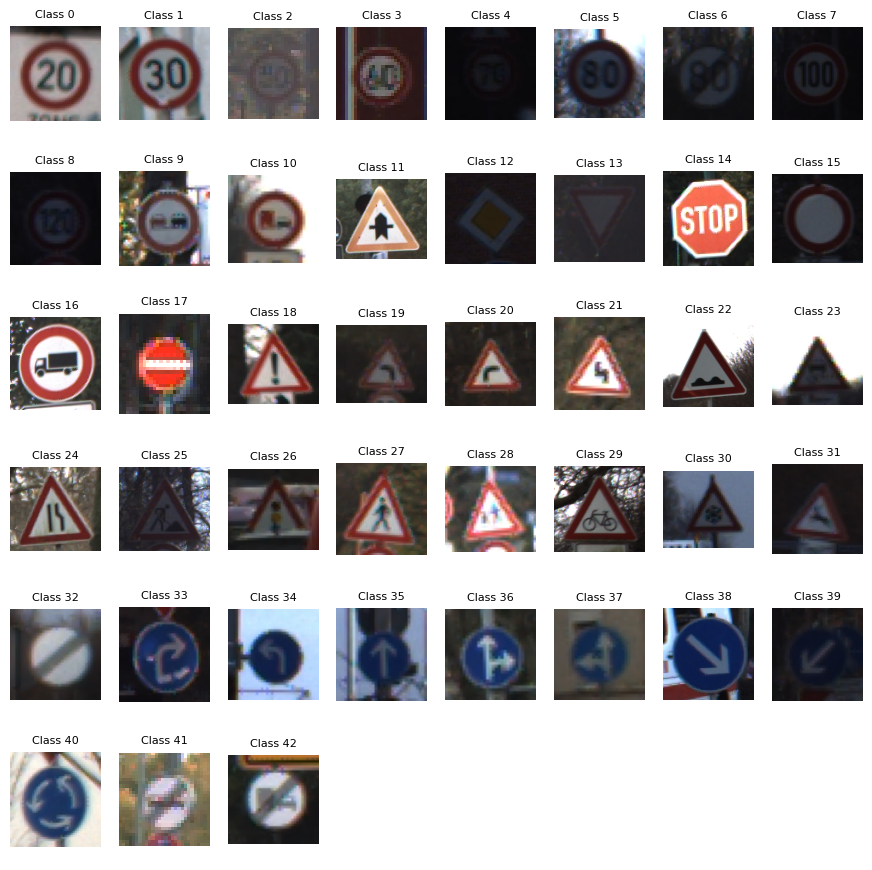

In [513]:
dl.display_train()


In [511]:
# dl.train_data
# List of images: tuple(path, class)

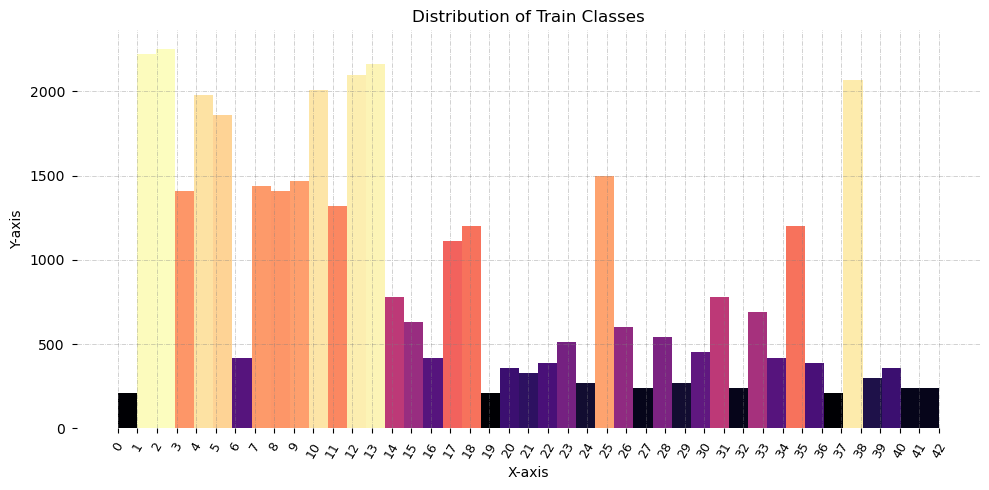

In [512]:
dl.display_distribution()